In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [2]:
from scipy.stats import norm
import torch
import MI
import marginal as mg
import bvcopula
from vine import CVine
import pickle as pkl
from train import conf
import select_copula
import utils

import matplotlib.pyplot as plt
import numpy as np


In [3]:
NSamp=10000
device = torch.device('cuda:0')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)
Nvar = 20
rhos = np.linspace(0.,1.,NSamp)

def cov(rho):
    return np.identity(Nvar)*(1-rho)+np.ones((Nvar,Nvar))*rho
# data = np.array([mvn.rvs(np.zeros(Nvar),cov(rho),1) for rho in rhos]).squeeze()
# data.shape

In [4]:
def det(rho,n):
    return ((n-1)*rho + 1)*(1-rho)**(n-1)
def entropy(rho,n):
    return -0.5*np.log(np.abs(det(rho,n)))/np.log(2)
def const_gauss(rho):
    return bvcopula.MixtureCopula(torch.ones(1,NSamp,device=device)*rho,
                                torch.ones(1,NSamp,device=device),
                                [bvcopula.GaussianCopula_Likelihood().copula])
# lin_gauss = bvcopula.MixtureCopula(torch.linspace(-.1,.9,NSamp,device=device).unsqueeze(0),
#                     torch.ones(1,NSamp,device=device),
#                     [bvcopula.GaussianCopula_Likelihood().copula])

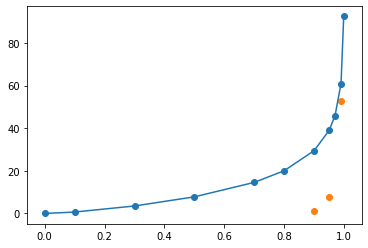

In [5]:
rho = [0,0.1,0.3,0.5,0.7,0.8,0.9,0.95,0.97,0.99,0.999]
plt.scatter(rho,[entropy(r,20) for r in rho])
plt.plot(rho,[entropy(r,20) for r in rho])
# plt.scatter([0.9,0.95,0.99],[1.1976,1.6785,2.8213])
# plt.scatter([0.9,0.95,0.99],[1.2099,1.6789,2.8351])
# plt.scatter([0.9,0.95,0.99],[1.1976,7.5109,12.1302])
# plt.scatter([0.9,0.95,0.99],[1.2099,1.6789,12.1398])
plt.scatter([0.9,0.95,0.99],[1.1976,7.5109,52.7])
# plt.scatter(rho,[r.item() for r in res])
# plt.scatter([0.99],[mi[:-1].sum()])

In [10]:
Nvar = 20
mc_size = int(800*20/Nvar) #8.9Gb
sem_tol = 0.01*Nvar

def const_rho_layers(rho,Nvar):
    copula_layers = []
    rho_cond = rho
    for i in range(Nvar-1):
        copula_layers.append([const_gauss(rho_cond) for j in range(Nvar-1-i)])
        rho_cond = (rho_cond - rho_cond**2) / (1 - rho_cond**2)
    return copula_layers

import tqdm
res = []
for r in tqdm.tqdm(rho):
    copula_layers = const_rho_layers(r,Nvar)
    vine = CVine(copula_layers,train_x,device=device)
    eT = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
    y=vine.sample().cpu().numpy()
    mi = np.ones(Nvar-1)*np.nan
    for i in range(1,Nvar):
        while mi[i-1]!=mi[i-1]:
            mi[i-1] = MI.train_MINE(y[:,:i],x=torch.tensor(y[:,i],device=device),H=500,device=device)
    KSG = MI.BI_KSG(x.reshape((*x.shape,1)),y,)
    res.append([entropy(r,Nvar),-eT.mean().item(),mi.sum(),-KSG[1]])
    print('Result: ',res[-1])

  9%|▉         | 1/11 [16:14<2:42:29, 974.92s/it]

Result:  [-0.0, -0.0, 2.9509277078323066, -8.112597485963493]


 18%|█▊        | 2/11 [32:28<2:26:10, 974.51s/it]

Result:  [0.6760029376078696, 0.6767659783363342, 3.454977633431554, -7.514376954914066]


 27%|██▋       | 3/11 [49:11<2:11:05, 983.20s/it]

Result:  [3.516364594097499, 3.5251691341400146, 4.744521152228117, -4.7499406168546185]


 36%|███▋      | 4/11 [1:06:58<1:57:36, 1008.12s/it]

Result:  [7.80384128861062, 7.827978610992432, 7.162594795227051, -0.07118491738846831]


 45%|████▌     | 5/11 [1:26:32<1:45:48, 1058.10s/it]

Result:  [14.582201523633444, 14.628515243530273, 11.193375498056412, 7.415543055377768]


 55%|█████▍    | 6/11 [1:46:56<1:32:18, 1107.67s/it]

Result:  [20.049355947431316, 20.10918617248535, 14.516607284545898, 13.1864603571677]


 64%|██████▎   | 7/11 [2:08:23<1:17:26, 1161.66s/it]

Result:  [29.469358005332023, 29.55150604248047, 20.644400417804718, 23.30479901236699]


 73%|███████▎  | 8/11 [2:30:23<1:00:27, 1209.11s/it]

Result:  [38.93245735512696, 39.025325775146484, 26.74404001235962, 32.741754193306726]


 82%|████████▏ | 9/11 [2:52:34<41:31, 1245.69s/it]  

Result:  [45.91938304810358, 46.02848434448242, 31.30005192756653, 39.389515265277424]


 91%|█████████ | 10/11 [3:15:31<21:25, 1285.09s/it]

Result:  [60.96255531530249, 61.116947174072266, 40.846519351005554, 52.86086502334977]


100%|██████████| 11/11 [3:39:13<00:00, 1195.76s/it]

Result:  [92.51467226270492, 92.75811004638672, 60.31922721862793, 77.89878984524438]


In [11]:
# with open(f"{home}/results/20D_Gauss.pkl","wb") as f:
#     pkl.dump(res,f)

In [12]:
res = []
r = 0.99
for Nvar in tqdm.tqdm(range(2,21)):
    mc_size = int(800*20/Nvar) #8.9Gb
    sem_tol = 0.01*Nvar
    copula_layers = const_rho_layers(r,Nvar)
    vine = CVine(copula_layers,train_x,device=device)
    eT = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
    y=vine.sample().cpu().numpy()
    mi = np.ones(Nvar-1)*np.nan
    for i in range(1,Nvar):
        while mi[i-1]!=mi[i-1]:
            mi[i-1] = MI.train_MINE(y[:,:i],x=torch.tensor(y[:,i],device=device),H=500,device=device)
    KSG = MI.BI_KSG(x.reshape((*x.shape,1)),y,)
    res.append([entropy(r,Nvar),-eT.mean().item(),mi.sum(),-KSG[1]])
    print('Result: ',res[-1])

  5%|▌         | 1/19 [00:49<14:56, 49.80s/it]

Result:  [2.8255438795029, 2.8251166343688965, 1.893771767616272, 2.7878847683788477]


 11%|█         | 2/19 [02:30<18:28, 65.18s/it]

Result:  [5.856200024431005, 5.8598151206970215, 3.9435200691223145, 5.694635243698314]


 16%|█▌        | 3/19 [04:48<23:10, 86.92s/it]

Result:  [8.97121478097797, 8.980850219726562, 6.063511848449707, 8.656100156557132]


 21%|██        | 4/19 [08:06<30:02, 120.15s/it]

Result:  [12.132542319243372, 12.148858070373535, 8.163822412490845, 11.595620886778699]


 32%|███▏      | 6/19 [18:21<47:23, 218.73s/it]

Result:  [18.534100737922405, 18.565662384033203, 12.409995913505554, 17.308123402916976]


 37%|███▋      | 7/19 [25:04<54:47, 273.92s/it]

Result:  [21.759836231246904, 21.80035972595215, 14.630223751068115, 20.14370867689987]


 42%|████▏     | 8/19 [32:52<1:00:54, 332.21s/it]

Result:  [24.996902904026104, 25.046056747436523, 16.742034912109375, 22.91373288506]


 47%|████▋     | 9/19 [41:55<1:05:54, 395.43s/it]

Result:  [28.242910325280373, 28.301862716674805, 19.05101227760315, 25.921097726771908]


 53%|█████▎    | 10/19 [52:06<1:09:01, 460.12s/it]

Result:  [31.496152833928836, 31.563304901123047, 21.119180560112, 28.52568263060765]


 58%|█████▊    | 11/19 [1:03:37<1:10:33, 529.23s/it]

Result:  [34.75537063877552, 34.83146667480469, 23.26780068874359, 31.395943177746634]


 63%|██████▎   | 12/19 [1:16:23<1:10:02, 600.39s/it]

Result:  [38.0196067944784, 38.10707473754883, 25.5964937210083, 34.25327430060482]


 68%|██████▊   | 13/19 [1:30:22<1:07:12, 672.01s/it]

Result:  [41.28811729226126, 41.3834228515625, 27.745537281036377, 36.845090885426316]


 74%|███████▎  | 14/19 [1:45:50<1:02:24, 748.82s/it]

Result:  [44.56031222304113, 44.66634750366211, 30.055666089057922, 39.76265053663568]


 79%|███████▉  | 15/19 [2:02:43<55:12, 828.07s/it]  

Result:  [47.83571595568441, 47.95054626464844, 32.08369159698486, 42.234676594575944]


 84%|████████▍ | 16/19 [2:21:07<45:32, 910.88s/it]

Result:  [51.11393940155195, 51.239540100097656, 34.183290004730225, 44.77865623755407]


 89%|████████▉ | 17/19 [2:40:57<33:08, 994.45s/it]

Result:  [54.39466021416002, 54.53004837036133, 36.54585289955139, 47.80695168978313]


 95%|█████████▍| 18/19 [3:01:53<17:52, 1072.99s/it]

Result:  [57.6776083464956, 57.82022476196289, 38.675286650657654, 50.19302505870903]


100%|██████████| 19/19 [3:24:33<00:00, 645.97s/it] 

Result:  [60.96255531530249, 61.11548614501953, 40.91647148132324, 52.836274348511374]


In [13]:
# with open(f"{home}/results/xD_Gauss.pkl","wb") as f:
#     pkl.dump(res,f)

In [6]:
with open(f"{home}/results/xD_Gauss.pkl","rb") as f:
    GxD = np.array(pkl.load(f))
with open(f"{home}/results/2D_Gauss.pkl","rb") as f:
    G2D = np.array(pkl.load(f))
with open(f"{home}/results/20D_Gauss.pkl","rb") as f:
    G20D = np.array(pkl.load(f))

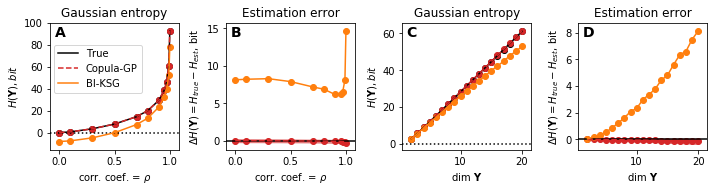

In [32]:
from matplotlib.ticker import FormatStrFormatter

def pns(ax,x,y,c,label=None):
    linestyle = 'solid'
    if c=='C3':
        linestyle='dashed'
    ax.plot(x,y,color=c,label=label,linestyle=linestyle)
    ax.scatter(x,y,color=c)
    
fig_width,fig_height = 10,2.75
# fig = plt.figure(figsize=(fig_width,fig_height))

fig, axes = plt.subplots(1,4,figsize=(fig_width,fig_height))

# l_mrg, b_mrg = 0.4/fig_width, 0.4/fig_height
# block_size = 4.8/fig_width
# plot_width, plot_height = 4.0/fig_width, 3.0/fig_height

# ax0 = fig.add_axes([0,0,1,1])

for ax in [axes[1],axes[3]]:
    ax.axhline(0,color='k')
    ax.set_ylabel(r"$\Delta H(\mathbf{Y}) = H_{true} - H_{est}$, bit")
    ax.set_title("Estimation error")
    
for ax in [axes[0],axes[2]]:
    ax.axhline(0,color='k',linestyle='dotted')
    ax.set_ylabel(r"$H(\mathbf{Y}), bit$")
    ax.set_title("Gaussian entropy")
    
for ax in axes[0:2]:
    ax.set_xlabel(r'corr. coef. = $\rho$')
    
for ax in axes[2:4]:
    ax.set_xlabel(r'dim $\mathbf{Y}$')
    
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))

# axes[0].set_title("20D multivariate Gaussian entropy",loc='left')
# axes[2].set_title("Multivariate Gaussian entropy for 2D-20D")
fig.text(0.080,0.80,r'A',fontweight='bold',fontsize=14)
fig.text(0.324,0.80,r'B',fontweight='bold',fontsize=14)
fig.text(0.568,0.80,r'C',fontweight='bold',fontsize=14)
fig.text(0.813,0.80,r'D',fontweight='bold',fontsize=14)

# ax20 = fig.add_axes([l_mrg,b_mrg,plot_width,plot_height])
pns(axes[0],rho,G20D[:,0],'k',label='True')
pns(axes[0],rho,G20D[:,1],'C3',label='Copula-GP')
# pns(axes[0],rho,G20D[:,2],'C4')
pns(axes[0],rho,G20D[:,3],'C1',label='BI-KSG')
axes[0].legend(loc=(0.03,0.45))

pns(axes[1],rho,G20D[:,0]-G20D[:,1],'C3')
# pns(axes[1],rho,G20D[:,0]-G20D[:,2],'C4')
pns(axes[1],rho,G20D[:,0]-G20D[:,3],'C1')
axes[1].fill_between(rho,G20D[:,0]-G20D[:,1]-20*0.01,
                     G20D[:,0]-G20D[:,1]+20*0.01,color='C3',alpha=0.5)

# axX = fig.add_axes([l_mrg+block_size,b_mrg,plot_width,plot_height])
pns(axes[2],range(2,21),GxD[:,0],'k')
pns(axes[2],range(2,21),GxD[:,1],'C3')
# pns(axes[2],range(2,21),GxD[:,2],'C4')
pns(axes[2],range(2,21),GxD[:,3],'C1')

pns(axes[3],range(2,21),GxD[:,0]-GxD[:,1],'C3')
# pns(axes[3],range(2,21),GxD[:,0]-GxD[:,2],'C4')
pns(axes[3],range(2,21),GxD[:,0]-GxD[:,3],'C1')
axes[3].fill_between(range(2,21),GxD[:,0]-GxD[:,1]-np.arange(2,21)*0.01,
                     GxD[:,0]-GxD[:,1]+np.arange(2,21)*0.01,color='C3',alpha=0.5)

fig.tight_layout(pad=1.0)
fig.savefig(f"{home}/results/suppl_fig_Gauss.pdf")

In [101]:
np.abs(GxD[:,0]-GxD[:,1])/np.arange(2,21)*0.01

array([2.13622567e-06, 1.20503209e-05, 2.40885969e-05, 3.26315023e-05,
       4.13033300e-05, 4.50880659e-05, 5.06543684e-05, 5.46153816e-05,
       5.89523914e-05, 6.10473338e-05, 6.34133634e-05, 6.72830331e-05,
       6.80753995e-05, 7.06901871e-05, 7.17689431e-05, 7.38827639e-05,
       7.52156423e-05, 7.50612713e-05, 7.64654149e-05])

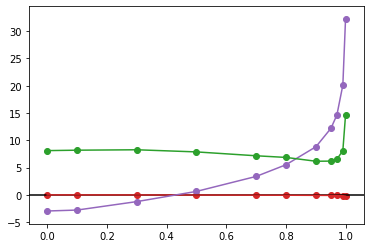

In [37]:

plt.axhline(0,color='k')
pns(rho,G20D[:,0]-G20D[:,1],'C3')
pns(rho,G20D[:,0]-G20D[:,2],'C4')
pns(rho,G20D[:,0]-G20D[:,3],'C2')

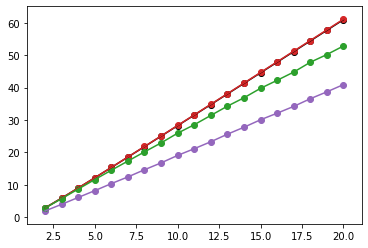

In [35]:
pns(range(2,21),GxD[:,0],'k')
pns(range(2,21),GxD[:,1],'C3')
pns(range(2,21),GxD[:,2],'C4')
pns(range(2,21),GxD[:,3],'C2')

In [31]:
copula_layers = const_rho_layers(0.999,Nvar)
vine = CVine(copula_layers,train_x,device=device)
%time eT = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
res.append(-eT.mean())

CPU times: user 1min 39s, sys: 6min 38s, total: 8min 17s
Wall time: 8min 17s


In [13]:
y=vine.sample().cpu().numpy()
KSG = MI.BI_KSG(x.reshape((*x.shape,1)),y,)
KSG

(-0.01424452657501707, -52.766238307216774)

In [29]:
mi = np.empty(Nvar-1)
for i in range(1,Nvar):
    %time mi[i-1] = MI.train_MINE(y[:,:i],x=torch.tensor(y[:,i],device=device),H=500,device=device)
    print(mi[i-1])

CPU times: user 25.2 s, sys: 21.6 s, total: 46.8 s
Wall time: 46.7 s
1.9120314121246338
CPU times: user 27.8 s, sys: 22 s, total: 49.8 s
Wall time: 49.7 s
2.032921552658081
CPU times: user 27.9 s, sys: 22.1 s, total: 50 s
Wall time: 49.9 s
2.059946060180664
CPU times: user 28 s, sys: 22.1 s, total: 50.1 s
Wall time: 49.9 s
2.1096270084381104
CPU times: user 28.2 s, sys: 22 s, total: 50.2 s
Wall time: 50 s
2.109982490539551
CPU times: user 28.3 s, sys: 21.8 s, total: 50.2 s
Wall time: 50 s
2.1472225189208984
CPU times: user 28.2 s, sys: 21.9 s, total: 50.1 s
Wall time: 49.9 s
2.165241003036499
CPU times: user 27.6 s, sys: 22.1 s, total: 49.7 s
Wall time: 49.6 s
2.1776511669158936
CPU times: user 27.9 s, sys: 21.8 s, total: 49.8 s
Wall time: 49.6 s
2.1809470653533936
CPU times: user 27.8 s, sys: 22.1 s, total: 49.9 s
Wall time: 49.7 s
2.1577587127685547
CPU times: user 27.9 s, sys: 22 s, total: 49.9 s
Wall time: 49.7 s
2.184964179992676
CPU times: user 28.3 s, sys: 21.6 s, total: 50 s
Wa

IndexError: index 20 is out of bounds for axis 1 with size 20

1.6141055864059737e+132


In [20]:
# from benchmarks import train4entropy
# y = vine.sample().cpu().numpy()
# _, eC = train4entropy(train_x,y,[bvcopula.GaussianCopula_Likelihood()],
#                       mc_size=mc_size,device=device,sem_tol=sem_tol,v=True)
# -eC.mean()

In [25]:
rho0 = torch.linspace(-0.1,.999,NSamp,device=device).unsqueeze(0)
copula_layers = const_rho_layers(rho0,Nvar)
vine = CVine(copula_layers,train_x,device=device)
# subvine = vine.create_subvine(torch.arange(0,NSamp,5))
# %time CopulaGP = subvine.stimMI(s_mc_size=1000, r_mc_size=10, sem_tol=0.01)

# CopulaGP
# vine.entropy(sem_tol=0.01, mc_size=1000, v=True).mean()

In [26]:
y=vine.sample().cpu().numpy()

In [27]:
new_y = y.copy()
new_y += np.repeat(y.prod(axis=-1).reshape(NSamp,1),Nvar,axis=-1)**(1/Nvar)
transformed_y = (np.argsort(new_y.flatten()).argsort()/new_y.size).reshape(new_y.shape)

In [29]:
MI.train_MINE(y,H=500,device=device)

In [30]:
KSG = MI.BI_KSG(x.reshape((*x.shape,1)),new_y,)
KSG

(0.2964823403839134, -1.178008281813543)

In [31]:
MI.Mixed_KSG(x,new_y)

(0.37393209303980024, -11.1778543336535)

In [ ]:
# MI.LNN_MI(x.reshape((*x.shape,1)),y,)/np.log(2)

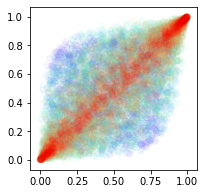

In [36]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
colors = cm.rainbow(np.linspace(0., 1., 10000))
plt.scatter(*transformed_y[:,[-2,-1]].T,alpha=0.05,color=colors)

In [37]:
samples = torch.tensor(transformed_y[:,[0,1]]).clamp(0.001,0.999).float().to(device)
out = '/home/nina/CopulaGP/synthetic_data/outputs'
(likelihoods, waic) = select_copula.select_with_heuristics(x,transformed_y[:,[0,1]],device,'benchmark',out,0,1,
                                    train_x=train_x, train_y=samples) #[torch.randperm(NSamp)]
likelihoods

Final model: Gaussian


[GaussianCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [8]:
likelihoodC =  [bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='180°'),
                bvcopula.GumbelCopula_Likelihood(rotation='0°')]
likelihoodU =  [bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='180°'),
                bvcopula.GumbelCopula_Likelihood(rotation='0°')] 

# samples = torch.tensor(transformed_y[:,[0,1]]).clamp(0.001,0.999).float().to(device)
# waic, model = bvcopula.infer(likelihoodC,train_x,samples,device=device) #[torch.randperm(NSamp)]
# waic

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,2))

utils.Plot_MixModel_Param_MCMC(ax,model,torch.linspace(0,1,50,device=device),np.linspace(0,1,50),particles=200)

In [13]:
#redirect logging here
def train4entropy(x,y,likelihood,shuffle=False):
    Nvar = y.shape[-1]
    data_layers = [torch.tensor(y).clamp(0.001,0.999).float().to(device)]
    copula_layers, model_layers = [], []
    for m in range(0,Nvar-1):
        copulas, layer, models = [], [], []
        for n in range(1,Nvar-m):
            print(m,n+m)
            if shuffle:
                x = x[torch.randperm(NSamp)]
            samples = data_layers[-1][...,[n,0]]
            waic, model = bvcopula.infer(likelihood,x,samples,device=device) 
            print(f'WAIC: {waic}')
            if shuffle:
                x = x[torch.randperm(NSamp)]
            with torch.no_grad():
                f = model(x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                layer.append(copula.ccdf(samples))
                models.append(model)
        data_layers.append(torch.stack(layer,dim=-1))
        copula_layers.append(copulas)
        model_layers.append(models)
    print('Trained')
    vine_trained = CVine(copula_layers,x,device=device)
#     entropies = vine_trained.entropy(sem_tol=0.1, mc_size=1000, v=True)
    return model_layers, vine_trained#, entropies

In [14]:
modelsC, vineC = train4entropy(train_x,transformed_y,likelihoodC, shuffle=False)
# modelsU, vineU, eU = train4entropy(train_x,transformed_y,likelihoodU,shuffle=True)

0 1


RuntimeError: CUDA out of memory. Tried to allocate 916.00 MiB (GPU 0; 10.76 GiB total capacity; 9.26 GiB already allocated; 398.38 MiB free; 9.50 GiB reserved in total by PyTorch)

In [51]:
# sample_layers = []
# for layer in modelsC:
#     copulas = []
#     for model in layer:
#         with torch.no_grad():
#             f = model(train_x).sample(torch.Size([2]))
#             print(f.shape)
#             copula = model.likelihood.get_copula(f)
#             copulas.append(copula)
#     sample_layers.append(copulas)
# vine = CVine(sample_layers,train_x,device=device)
# entropies = vine.entropy(sem_tol=0.01*Nvar, mc_size=3000, v=True)

tensor(-5.0656, device='cuda:1')
tensor(-5.0362, device='cuda:1')
tensor(-5.0386, device='cuda:1')


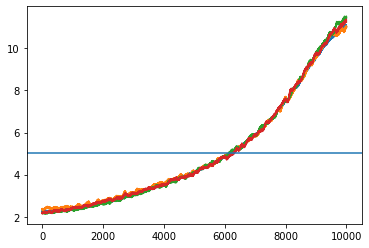

In [52]:
plt.plot(-eC.cpu().numpy())
for H in Hs:
    print(H.mean())
    plt.plot(-H.cpu().numpy())
plt.axhline(-eC.mean().cpu().numpy())
# (eU-eC).mean()

In [14]:
entropies.mean()-eC.mean()

tensor(-0.0793, device='cuda:1')

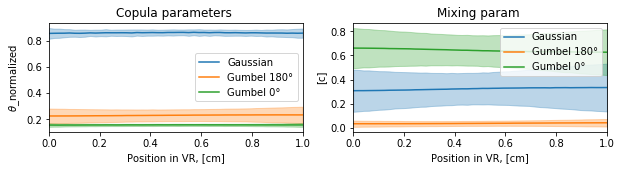

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,2))

utils.Plot_MixModel_Param_MCMC(ax,modelsC[0][0],torch.linspace(0,1,50,device=device),np.linspace(0,1,50),particles=200)

In [28]:
# data_layers = [torch.tensor(transformed_y).clamp(0.001,0.999).float().to(device)]
# copula_layers = []
# for m in range(0,Nvar-1):
# #     out_dir = f'{conf.path2outputs}/{exp_pref}/layer{m}'
#     copulas, layer = [], []
#     for n in range(1,Nvar-m):
#         print(m,n+m)
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = bvcopula.MixtureCopula_Likelihood([bvcopula.IndependenceCopula_Likelihood(),
#                                                         bvcopula.GaussianCopula_Likelihood(),
#                                         bvcopula.GumbelCopula_Likelihood(rotation='180°')])
#         copula, plot_loss = fit(likelihood, samples, n_epoch=200, lr=0.02)
#         copulas.append(copula)
#         layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)

0 1


In [8]:
results_file = f"{home}/MI_sqGaussH_dump1.pkl"
with open(results_file,'rb') as f:
    results1 = pkl.load(f)[:-1]
results_file = f"{home}/MI_sqGaussH_dump2.pkl"
with open(results_file,'rb') as f:
    results2 = pkl.load(f)
results = results1 + results2

In [9]:
# with open(results_file,'wb') as f:
#     pkl.dump(results0,f)

In [10]:
results[0][2]

[[1.7369991540908813, 0],
 [0.5944793345710434, 0.5854079795048068],
 [0.6506400740826891, 0.6217746436305439],
 [0.7280912181587887,
  0.840709671518702,
  0.8925313118940327,
  0.9605511382408769]]

In [11]:
Ns = np.array([res[0][0] for res in results])
Ns

array([6, 6, 6, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5])

In [12]:
(-torch.ones(1)).sign()

tensor([-1.])

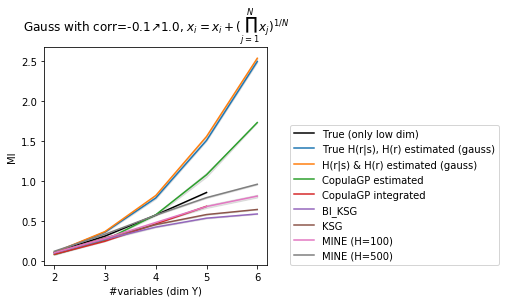

In [13]:
plt.figure(figsize=(4,4))
def line(H,label,cut=Ns.max(),color=None):
    NN = cut+1-Ns.min()
    A = np.zeros((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        if np.any(Ns==n):
            A[1,i] = H[Ns==n].mean()
            A[2,i] = H[Ns==n].std()
    plt.plot(A[0][A[1]!=0],A[1][A[1]!=0],label=label,color=color)
    plt.fill_between(A[0][A[1]!=0],(A[1]-A[2])[A[1]!=0],(A[1]+A[2])[A[1]!=0],color='grey',alpha=0.2)
line(np.array([res[1][0] for res in results]),"True (only low dim)",cut=5,color='black')
for i,label in enumerate(["True H(r|s), H(r) estimated (gauss)","H(r|s) & H(r) estimated (gauss)"]):
    line(np.array([res[1][i+1] for res in results]),label)
for i,label in enumerate(["CopulaGP estimated","CopulaGP integrated"]):
    line(np.array([res[2][0][i] for res in results]),label)
for i,label in enumerate(["BI_KSG","KSG"]):
    line(np.array([res[2][i+1][0] for res in results]),label)
line(np.array([res[2][3][1] for res in results]),"MINE (H=100)")
line(np.array([res[2][3][-1] for res in results]),"MINE (H=500)")
# for i,H in enumerate([50,100,200,500]):
#     line(np.array([res[2][3][i] for res in results])/np.log(2),f"MINE (H={H})")
# plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + \prod_{j=1}^{N} x_j$")
plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + (\prod_{j=1}^{N} x_j)^{1/N}$")
plt.xlabel("#variables (dim Y)")
plt.ylabel("MI")
plt.legend(loc=(1.1,0));